# Expanding Nutri-Score : take your menu to the next level

## Overview of Milestone 3
During this Milestone, we will present different things such as the cleaning part (part 2), and the 2 different algorithm that we create that we use in our app. You will see more informations about our app and our project in general <a href="https://nutriteam.github.io/Nutri_Score/home.html" target= "_blanck">here</a>.

In [125]:
import pandas as pd
from random import randint
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

from computeNutriScore import computeNutriScore
import df_nutri_create as nutri
from Rec_nutri import Rec_text
from email_nutri import Send_rec
from product_better import find_healthier_product
from Algo_main import algo

# Data path
DATA_FOLDER = './data/'

## Cleaning - part 2
With the database that we complete - see Milestone 2 - we have to cleaning and complete a little bit more. Frist of all, we see that some product name as extreme long name so it reduces the readibility for our app. With them, we will keep only the begining of the name before that a common string is detected ([même code...]). For our app again, we decide to add brands. Finally to improve the speed of our algorithm to detect healthier product than the one selected by the users, we compute the grade and the NutriScore for each product of the database.

```python
def Compute_energy(fat, sugar, prot, fiber, margin):
    ''' Computes energy with a margin in kJ. source : https://en.wikipedia.org/wiki/Food_energy '''

    energy = (37 * fat + 17 * (sugar + prot) + 8 * fiber) - margin
    if energy < 0:
        return 0
    return energy

def set_coherent_values(df):
    """ Compute coherent value for food values. Set incoherent values to NaN or assign a valid value. """
    for i in range(len(df)):
        
        # energy
        value = df.iat[i, 2]
        if  value < 0 or value > 4000:
            df.iat[i, 2] = np.nan
        
        # other columns
        for column in range(3, len(df.columns)):
            value = df.iat[i, column]
            if (value < 0) or (value > 100):
                df.iat[i, column] = np.nan
                
        # Salt / Sodium (should be perfectly correlated)        
        if np.isnan(df.iat[i, 6]):
            if ~np.isnan(df.iat[i, 7]):
                if ((df.iat[i, 7] * 2.5) <= 100):
                    df.iat[i, 6] = df.iat[i, 7] * 2.5 # Salt = Sodium * 2.5
                else:
                    df.iat[i, 7] = np.nan # Sodium must be a error value
        else:
            if np.isnan(df.iat[i, 7]):
                if ((df.iat[i, 6] / 2.5) <= 100):
                    df.iat[i, 7] = df.iat[i, 6] / 2.5 # Sodium = Salt / 2.5
                else:
                    df.iat[i, 6] = np.nan # Salt must be a error value
        
        # Saturated Fat / Fats                   
        if df.iat[i, 4] > df.iat[i, 3]: #saturated fat > fat
            df.iat[i, 3] = df.iat[i, 4]
        
        # Fruit-Vegetables-Nut Real / Estimate
        if ~np.isnan(df.iat[i, 8]) & np.isnan(df.iat[i, 9]):
            df.iat[i, 9] = df.iat[i, 8] # Estimate fruits-vegetables-nuts = Real
        if ~np.isnan(df.iat[i, 8]) & (df.iat[i, 9] > df.iat[i, 8]):
            df.iat[i, 9] = df.iat[i, 8]
        
        # Energy
        Fat, Sugar, Prot, Fiber = 0,0,0, 0
        if ~np.isnan(df.iat[i, 3]):
            Fat = df.iat[i, 3]
                
        if ~np.isnan(df.iat[i, 5]):
            Sugar = df.iat[i, 5]
                
        if ~np.isnan(df.iat[i, 11]):
            Prot = df.iat[i, 11]
            
        if ~np.isnan(df.iat[i, 10]):
            Fiber = df.iat[i, 10]
        
        energy_comput = Compute_energy(Fat, Sugar, Prot, Fiber, 150)
        
        if np.isnan(df.iat[i, 2]) | (df.iat[i, 2] < energy_comput):
            df.iat[i, 2] = energy_comput       
            
    return df

# Load previous filling database
data_food_final = pd.read_csv(DATA_FOLDER + 'data_food_final.csv', index_col  = [0])
data_food_final = set_coherent_values(data_food_final)

# Load raw Data and Clean
data_raw = pd.read_csv(DATA_FOLDER + 'en.openfoodfacts.org.products.csv',
                       delimiter = '\t', low_memory = False)
data_clean = data_raw.copy()

# Drop duplicates according to the code
data_clean.drop_duplicates(subset = 'code', keep = False, inplace = True)
data_clean.set_index('code', inplace = True)



# set value by default
data_food_final['Predicted_NutriScore_grade'] = np.nan
data_food_final['Predicted_NutriScore_score'] = np.nan
data_food_final['Brands'] = ' '

for index in range(len(data_food_final)):
    if (index % 100==0):
        print(str(index*100/len(data_food_final))[:6],'%')
        
    product = data_food_final.iloc[[index
    
    # Compute NutriScore
    nutriscore, final_score = computeNutriScore(product)
    
    # Complete the dataset with the computed values
    data_food_final.loc[product.index[0], 'Predicted_NutriScore_grade'] = nutriscore
    data_food_final.loc[product.index[0], 'Predicted_NutriScore_score'] = final_score
    
    # Search for common feature for the product name with long name
    regex_group = re.search('(.*)(?=même code)', product.product_name[0])
    
    if regex_group != None:
        data_food_final.loc[product.index[0], 'product_name'] = regex_group.group(0)[:-1]
    
    # add brands                               
    Brands = data_clean.at[product.index[0], 'brands']
    if str(Brands) != 'nan':
        data_food_final.loc[product.index[0], 'Brands'] = Brands
    
    

data_food_final.to_csv('OpenFoodFacts_final.csv')
```

## General NutriScore Algorithm
To give informations about a unique NutriScore for the users, we develop a general NutriScore algorithm. You can see the code for it inside `df_nutri_create.py ` file. 

These are the steps that inside our algorithm
* We take the barcode and the quantity [in g/ml] for each product that the users eat and that inside the databse of Open Food Facts. If the users eats raw product, we take the name of the product and its quantity [in g/ml].
* We create a new dataframe that contains all the product that are in the Open Food Facts database and add a column of quantity.
* If the users eats raw product, we will search by using the API (see Milestone 2) for the product and add it to our new dataframe.
* We put inside real fruits/vegetables/nuts the value that give our first NutriScore algorithm for the fruits contents of each product. It is an essential step because after some steps, we will call our original NutriScore algorithm. This one will search at the begining if a value is inside the real fruits/vegetables/nuts. 
* We multiply each column by the quantity of each product. 
* We separate beverages and non-beverages because it is not the same calculation for each case. We decide also to give a NutriScore grade for beverages and non-bevearages case to our user. It will improve by this way the informations. The users can know where he/she has to improve its diatry. 
* For beverages, we separate water to non-pure water. Pure water has automaticaly a A grade. The other beverages cannot have A as grade. 
* Du to our original NutriScore algorithm, we have to take care of some exeptions for the non-beverages. Some product must have 0 as protein. 
* We sum the dataframe and divide by the sum of quantity. We put the proportion of each column of this 'big product' for 100g. 
* We call our orginal NutriScore algorithm to compute the score and the grade.

During the process, we exctract also important informations that we can use to give recomendations to our user. 

In [2]:
data_food_final = pd.read_csv(DATA_FOLDER + 'OpenFoodFacts_final.csv', index_col  = [0], low_memory = False)

In [4]:
list_product = []
number_of_product = 1000

for index in range(number_of_product):
    list_product.append((data_food_final.iloc[[randint(0, len(data_food_final))]].index[0], randint(1, 200)))

Dict_ = nutri.main_nutri(list_product, data_food_final, [])

if Dict_['Score_Beverages'] != None:
    print('The grade for your beverages is {} for a score of {}'\
          .format(Dict_['NutriScore_Beverages'].upper(), Dict_['Score_Beverages']))
    
if Dict_['Score_Non_Beverages'] != None:
    print('The grade for your non-beverages is {} for a score of {}'\
          .format(Dict_['NutriScore_Non_Beverages'].upper(), Dict_['Score_Non_Beverages']))
    
print('You drink {:.3f} ml'.format(Dict_['Beverages_quantites']))
print('You drink {:.3f} % of non pure-water (eg. sodas)'.format(Dict_['Soda_ratio']))
print('You eat {:.3f} g of fiber'.format(Dict_['Fiber']))
print('You eat {:.3f} % of fruits, vegetables and/or nuts'.format(Dict_['Fruits']))
print('You eat {:.3f} mg of sodium'.format(Dict_['Sodium']*1000))
print('You eat {:.3f} g of protein'.format(Dict_['Protein']))
print('Your energy amount is {:.3f} kJ'.format(Dict_['Energy']))
print('You eat {:.3f} g of sugar'.format(Dict_['Sugar']))
print('You eat {:.3f} g of fat'.format(Dict_['Fat']))

The grade for your beverages is E for a score of 15
The grade for your non-beverages is C for a score of 6
You drink 13777.000 ml
You drink 98.497 % of non pure-water (eg. sodas)
You eat 2279.394 g of fiber
You eat 24.250 % of fruits, vegetables and/or nuts
You eat 467002.228 mg of sodium
You eat 6978.558 g of protein
Your energy amount is 1034954.708 kJ
You eat 12683.502 g of sugar
You eat 12741.956 g of fat


To improve the readibility of our app, we will give feedback by email to our user. First of all, we check with the recomendation of the SSN (see Milestone 2) so we can give precise feedback. After that, we send by email the text create of the first function. 

In [ ]:
text = Rec_text(True, 22, 1.6, 1, 75, Dict_)
Send_rec('EMAIL@EMAIL.EMAIL', text)

## Healthier product
To improve the diatry of our user, we will select based on each product selected by the users if one is better for him/her. You can see on `product_better.py` the algorithm. 

Our algorithm will take first of all the tag of the product that is more specifiq (i.e the less common in the database). We take all the product inside the database that have the same tag. Inside these 'same' product, we take a look for one that have a better score. 

In [8]:
def relevant_tag(dic, tags, threshold = 5):
    """ Returns the least frequent tag from the list, who however has more than 'threshold' 
    correspondancies in the database """
    
    # Init
    dict_, sort = {}, []
    
    for tag in tags:
        dict_[tag] = dic[tag]
    
    # Keep only tag which have more occurencies than threshold
    dict_ = {k: v for k, v in dict_.items() if v >= threshold}
    if len(dict_) > 0:
        # Returns the most relevant tags
        sort = sorted(dict_, key = dict_.get, reverse=False)
        return sort
    else :
        return None

In [9]:
def list_df_tags(data_food):
    """ List of all the tags found in the dataset. Count the number of occurences and rank them
        according to this number. """
    
    # Split the tags found in the categories_tags columns
    all_tags = [tags.split(',') for tags in list(data_food[['categories_tags']].dropna().categories_tags)]
    
    # Init
    list_tags = []
    
    # List them
    for tags in all_tags:
        for tag in tags:
            list_tags.append(tag)
    
    # Return the list by number of occurences 
    return dict(Counter(list_tags).most_common())

In [10]:
dic_tag = list_df_tags(data_food_final)

In [20]:
for product in list_product[:5]:
    replaced, best_product, best_sc, best_code, old_sc, old_gr, new_gr =\
    find_healthier_product(product, data_food_final, dic_tag)
    
    if replaced:
        print('''We suggest to you to replace the product "{}" by this other product https://world.openfoodfacts.org/product/{} {} that has a better Nutri-Score.Your product has a grade of {} and the one that we suggest to you has a grade of {}.\n'''\
            .format(data_food_final.loc[product[0]][0], best_code, best_product[0] + ' (' + best_product[-1] + ')',\
            old_gr, new_gr))
    else:
        print('''Your product "{}" is the best in its category.'''.format(data_food_final.loc[product[0]][0]))

We suggest to you to replace the product "Asperges vertes" by this other product https://world.openfoodfacts.org/product/3292590830830 Asperges Vertes ( ) that has a better Nutri-Score.Your product has a grade of A and the one that we suggest to you has a grade of A.

We suggest to you to replace the product "Chewy White Choc Chip" by this other product https://world.openfoodfacts.org/product/3229820785639 Barre de son d'avoine saveur amande Gayelord Hauser (Gayelord Hauser) that has a better Nutri-Score.Your product has a grade of C and the one that we suggest to you has a grade of A.

We suggest to you to replace the product "J'♥ le lait d'ici demi-écrémé stérilisé UHT" by this other product https://world.openfoodfacts.org/product/20757595 Milbona Haltbare Fettarme Milch (Milbona) that has a better Nutri-Score.Your product has a grade of B and the one that we suggest to you has a grade of A.

We suggest to you to replace the product "Infusion tilleul citron" by this other product htt

We did the same thing as before for the recomendations.

In [14]:
text = Better_product_rec(list_product[:5], data_food_final)
Send_rec('EMAIL@EMAIL.EMAIL', text)

## Main structure
We create a general function `algo` that take care of everything as explained above.

In [5]:
dict_product = {
'Product' : list_product,
'API' : [('Cookies', 40), ('Banana', 100)],
}

dict_settings = {
'Rec' : True,
'Day' : 1,
'Name' : 'Bruttin',
'Surname' : 'Valentin',
'Email' : 'valentin.bruttin@epfl.ch',
'Age' : 23,
'Sex' : True,
'Pal' : 1.6,
'Weight' : 59,
}

text = algo(dict_product, dict_settings, data_food_final)

## APP

We create an App that is available for PC. You will see more information by reading our Data Story

## Visualization
To visualize healthier product, we will compute for each tag the minimum score and at the same time, the maximum one. With that, we can compute for each product the differences between its score and the minimum.

In [98]:
list_tags = [key for key,value in dic_tag.items() if value >= 10]
value_min = []
value_max = []
diff_score = []

for tag in list_tags:
    data_ = data_food_final[data_food_final.categories_tags.str.contains(tag, case = False) &\
                            (data_food_final['Predicted_NutriScore_grade'] != 'Error')]
    min_ = min(data_['Predicted_NutriScore_score'].values)
    max_ = max(data_['Predicted_NutriScore_score'].values)
    value_min.append(min_)
    value_max.append(max_)
    
    diff = [score - min_ for score in data_['Predicted_NutriScore_score'].values]
    diff_score.extend(diff)

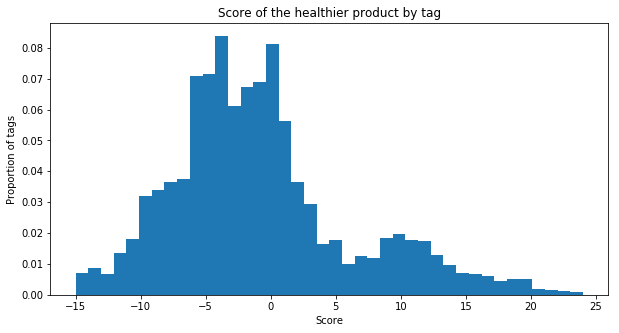

In [90]:
plt.figure(figsize = (10, 5))
plt.hist(value_min, bins=40, density= True);
plt.title('Score of the healthier product by tag');
plt.xlabel('Score');
plt.ylabel('Proportion of tags');

As we can observe, we have a large distribution of the minimum score. Most of healthier products are really healthy (negative score). But we can observe that some healthier product has a quite big score (>20). 

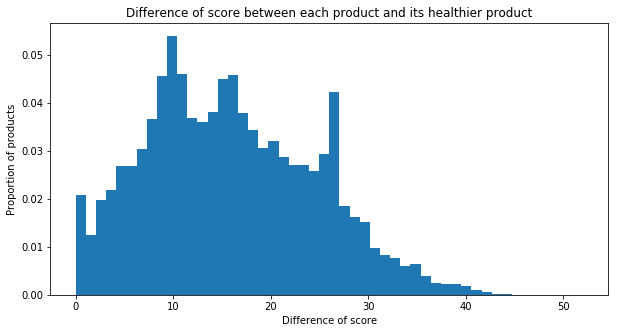

In [89]:
plt.figure(figsize = (10, 5))
plt.hist(diff_score, bins=50, density=True);
plt.title('Difference of score between each product and its healthier product');
plt.xlabel('Difference of score');
plt.ylabel('Proportion of products');

First of all, we see that 2% of the products are the better ones. Indeed, they are represented by the bins at 0. 
The biggest difference is 52. So we have also a large palette of differences but they are concise around 10. 

Scatter between max and min score for each tag


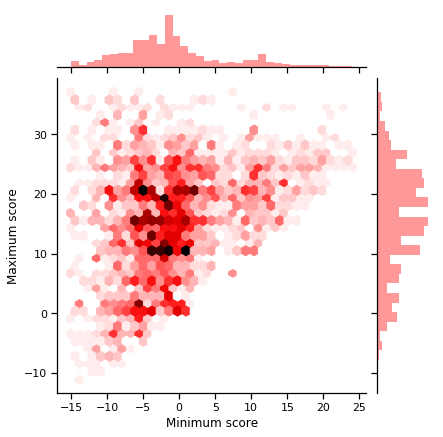

In [142]:
print('Scatter between max and min score for each tag')
gr = (sns.jointplot(x=value_min, y=value_max, kind="hex", color="r").set_axis_labels("Minimum score", "Maximum score"));

In [151]:
diff = [value_max[index] - value_min[index] for index in range(len(value_max))]

up_50 = [(tuple_[0], tuple_[1]) for tuple_ in list(zip(list_tags, diff)) if tuple_[1] >=50]
up_50

[('en:plant-based-foods-and-beverages', 51.0),
 ('en:plant-based-foods', 51.0),
 ('en:groceries', 50.0),
 ('', 52.0)]

With this scatter plot, wich represent the distribution for each tag between its highest score and its lowest one. The line is expected because we cannot have a maximum less than the minimum. But we observe that we have a large distribution of maximum. We understand also base on this graph that the highest difference seen on the previous graph is the point on the upper left. We can detect that these big difference are for the tags, 'en:plant-based-foods-and-beverages' and 'en:plant-based-foods'. These tags are the most popular one and are express in the majority of the product. So it represent the biggest difference of score for the whole database. The tag '' may be an artefact of the computation. Indeed, this tag are express in each product so it is not a correct tag.

We see also with the dark points wich represent a larger number of points situated there, that most of the tags have a minimum score around 0 and an maximum around 10,15. So it is consitent with the previous graph.